# 🌟 Lightweight PatchTST and HNSW
A walk‑through that:
1. Loads **GiftEvalPretrain**
2. Builds sliding‑window samples
3. Trains **PatchTST**
4. Visualises every major data hop
5. Evaluates on test data
6. HNSW vector indexing and recall comparision to Brute force

## 0️⃣ Install once if needed

In [1]:
# !pip install -q transformers datasets uni2ts accelerate tqdm matplotlib

## 1️⃣ Imports & hyper‑params

In [5]:
from pathlib import Path
from datasets import load_dataset
from transformers import PatchTSTConfig, PatchTSTForPrediction
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from accelerate import Accelerator
from tqdm.auto import tqdm
import numpy as np

# 🔧 change these freely
PRED_LEN      = 96
CTX_MULTI     = 4
BATCH_SIZE    = 128
EPOCHS        = 10
LR            = 2e-4

CTX_LEN = PRED_LEN * CTX_MULTI
OUTPUT_DIR = Path('nb_ckpts'); OUTPUT_DIR.mkdir(exist_ok=True)

accel = Accelerator(mixed_precision='no')
device = accel.device
print('Running on', device)

/Users/mridul.sarkar/Documents/TransformerTraining/transformersenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on mps


## 2️⃣ Load GiftEvalPretrain

In [17]:
from datasets import load_dataset
from pathlib import Path

arrow_path = "./GiftEvalPretrain/australian_electricity_demand/data-00000-of-00001.arrow"

ds = load_dataset(
    "arrow",
    data_files=str(arrow_path),
    split="train",
)

print("Rows loaded:", len(ds))
print("Columns:", ds.column_names)

Rows loaded: 5
Columns: ['item_id', 'start', 'freq', 'target']


### 👉 Convert to Pytorch Tensor, transpose so Channels,Time -> Time,Channels & peek at raw snippet

Example series shape: torch.Size([230400, 1])
Vars: 1


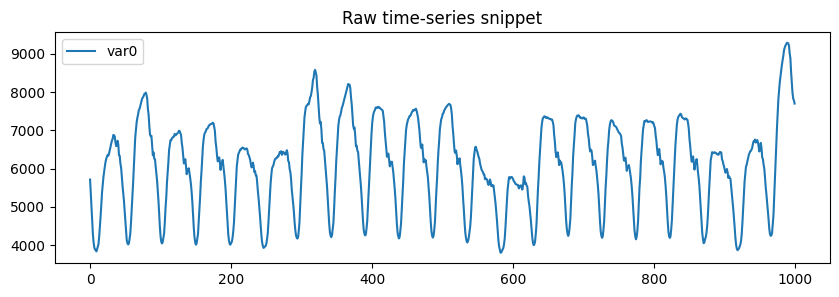

In [18]:
series = []
for rec in ds:
    arr = torch.tensor(rec["target"], dtype=torch.float32)  # shape (C, T)
    if arr.ndim == 1:
        arr = arr.unsqueeze(0)   # (1, T)
    series.append(arr.T)    # (T, C)

print("Example series shape:", series[0].shape)

NUM_VARS = series[0].shape[1] # grab first time slice then number of vars in that slice

print('Vars:', NUM_VARS)

plt.figure(figsize=(10,3))
for i in range(min(5, NUM_VARS)):
    plt.plot(series[0][:1000, i], label=f'var{i}')
plt.legend(); plt.title('Raw time‑series snippet'); plt.show()

## 3️⃣ Windowing: context ➜ future pairs

In [39]:
def make_windows(series: torch.Tensor, ctx: int, horizon: int):
    """
    Yield (past, future) pairs from a 2-D tensor  (T, C).
/
    past     : shape (ctx,     C)
    future   : shape (horizon, C)
    """
    total_steps = series.shape[0]

    for end_idx in range(ctx, total_steps - horizon):
        start_idx = end_idx - ctx
        past   = series[start_idx:end_idx]          # [ctx  , C]
        future = series[end_idx:end_idx + horizon]  # [horizon, C]
        yield past, future

from torch.utils.data import Dataset
class WindowDataset(Dataset):
    """
    Turn a list of time-series into a PyTorch Dataset of (past, future) pairs.
    """
    def __init__(self, sequences, ctx, horizon):
        self.samples = [
            pair
            for seq in sequences
            for pair in make_windows(seq, ctx, horizon)
        ]
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        past, future = self.samples[idx]
        return {"past": past, "future": future}

# ---------- build the DataLoader ----------
def collate(batch):
    return {
        "past":   torch.stack([item["past"]   for item in batch]),
        "future": torch.stack([item["future"] for item in batch]),
    }

train_ds = WindowDataset(series, ctx=CTX_LEN, horizon=PRED_LEN)
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate,
)
print("Windows:", len(train_ds))

Windows: 1151184


### Visualise one context‑future split

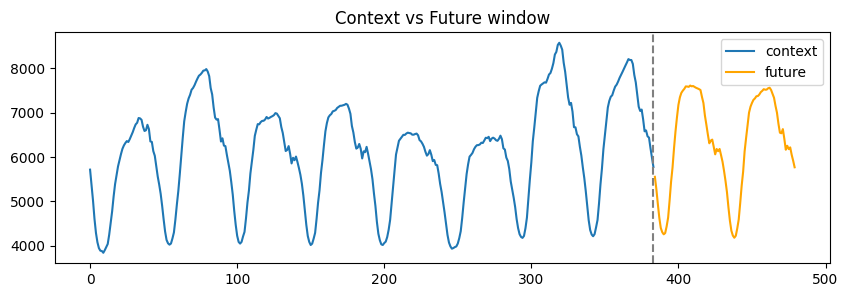

In [41]:
sample_p, sample_f = train_dl.dataset[0]['past'], train_dl.dataset[0]['future']
plt.figure(figsize=(10,3))
plt.plot(sample_p[:,0], label='context')
plt.plot(range(len(sample_p), len(sample_p)+len(sample_f)), sample_f[:,0], label='future', color='orange')
plt.axvline(len(sample_p)-1, ls='--', c='gray');
plt.legend(); plt.title('Context vs Future window'); plt.show()

## 4️⃣ Build PatchTST

In [21]:
# Init our model and optimizer
cfg = PatchTSTConfig(num_input_channels=NUM_VARS, context_length=CTX_LEN, prediction_length=PRED_LEN,
                     patch_length=16, stride=16, d_model=128)
model = PatchTSTForPrediction(cfg).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
model, opt, train_dl = accel.prepare(model, opt, train_dl)

In [44]:
# ─── Split full windowed dataset into train/test ──────────────────
from torch.utils.data import random_split, DataLoader

full_ds = WindowDataset(series, ctx=CTX_LEN, horizon=PRED_LEN)
n_total = len(full_ds)
n_test = int(0.2 * n_total)
n_train = n_total - n_test
train_ds, test_ds = random_split(
    full_ds,
    [n_train, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
test_loader   = DataLoader(test_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
print(f"Train windows: {n_train}, Test windows: {n_test}")


Train windows: 920948, Test windows: 230236


## 5️⃣ Train PatchTST

In [12]:
def train_one_epoch(model, loader, optimizer, accelerator):
    """
    Run a single epoch and return the mean loss.
    Expects model already on `accelerator.device`.
    """
    model.train()
    total_loss, num_batches = 0.0, 0

    for batch in loader:
        # ← MOVE EVERYTHING TO THE RIGHT DEVICE ←
        batch = {k: v.to(accelerator.device) for k, v in batch.items()}

        # forward + backward
        outputs = model(
            past_values   = batch["past"],
            future_values = batch["future"],
        )
        loss = outputs.loss

        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        total_loss   += loss.item()
        num_batches  += 1

    return total_loss / num_batches


# -------------------------------------------------------------------
# training loop
# -------------------------------------------------------------------
for epoch in range(EPOCHS):
    mean_mse = train_one_epoch(model, train_loader, opt, accel)
    accel.print(f"Epoch {epoch}: avg MSE = {mean_mse:.4f}")


Epoch 0: avg MSE = 101511.4084
Epoch 1: avg MSE = 71524.6105
Epoch 2: avg MSE = 64806.4757
Epoch 3: avg MSE = 61083.7525
Epoch 4: avg MSE = 58155.8188
Epoch 5: avg MSE = 55347.2843
Epoch 6: avg MSE = 52722.4515
Epoch 7: avg MSE = 50074.7229
Epoch 8: avg MSE = 47669.2189
Epoch 9: avg MSE = 45153.3090


### Prediction vs Truth (single window)

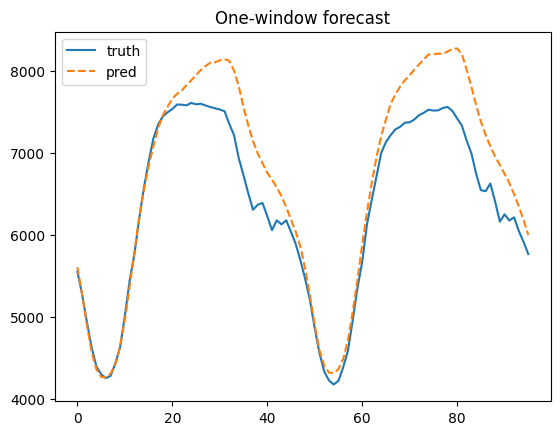

In [13]:
model.eval()
with torch.no_grad():
    pred = model(past_values=sample_p.unsqueeze(0).to(device)).prediction_outputs.cpu()[0,:,0]
plt.plot(sample_f[:,0], label='truth'); plt.plot(pred, label='pred', ls='--'); plt.legend(); plt.title('One‑window forecast'); plt.show()

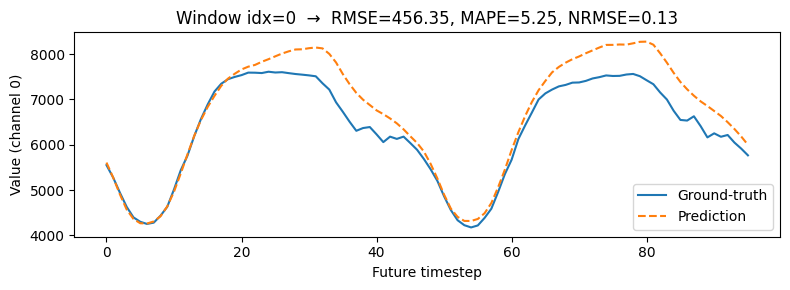

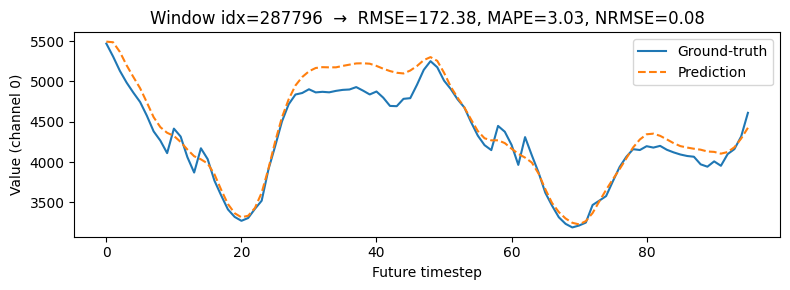

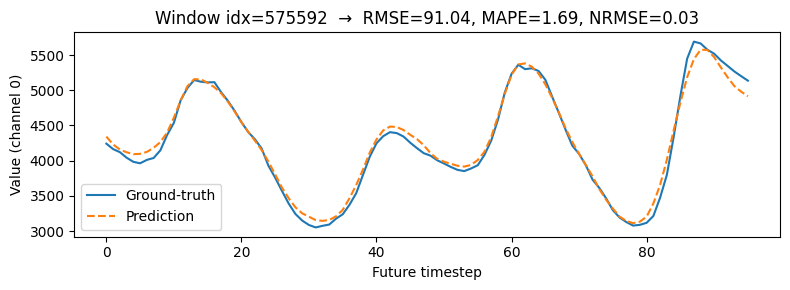

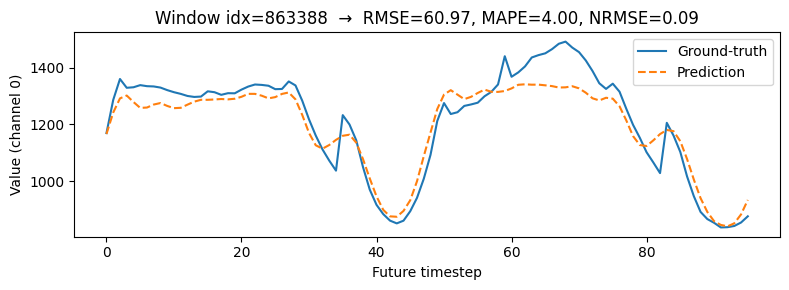

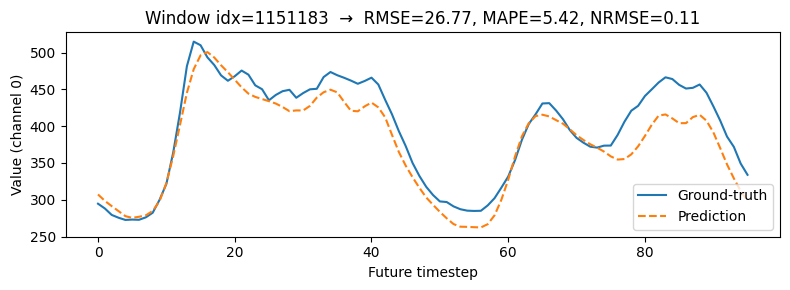

In [43]:
def rmse(a: torch.Tensor, b: torch.Tensor):
    return torch.sqrt(torch.mean((a - b)**2)).item()

def mape(a: torch.Tensor, b: torch.Tensor):
    return (torch.mean(torch.abs((a - b) / a)) * 100).item()

def nrmse(a: torch.Tensor, b: torch.Tensor):
    denom = a.max() - a.min()
    return (torch.sqrt(torch.mean((a - b)**2)) / denom).item()

model.eval()

# Pick a few windows to inspect (start, ¼-point, halfway, ¾-point, end-1)
N = len(train_dl.dataset)
indices = [0, N//4, N//2, 3*N//4, N-1]

for idx in indices:
    past = train_dl.dataset[idx]["past"]      # (CTX_LEN, C)
    fut  = train_dl.dataset[idx]["future"]    # (PRED_LEN, C)

    # forecast channel 0
    with torch.no_grad():
        pred = model(past_values=past.unsqueeze(0).to(device)) \
                    .prediction_outputs.cpu()[0, :, 0]  # (PRED_LEN,)

    # compute errors
    truth = fut[:, 0]
    rmse_metrics  = rmse(truth,pred)
    mape_metrics   = mape(truth,pred)
    nrmse_metrics = nrmse(truth,pred)

    # plot
    plt.figure(figsize=(8, 3))
    plt.plot(truth.numpy(), label="Ground-truth")
    plt.plot(pred.numpy(),  ls="--", label="Prediction")
    plt.title(f"Window idx={idx}  →  RMSE={rmse_metrics:.2f}, MAPE={mape_metrics:.2f}, NRMSE={nrmse_metrics:.2f}")
    plt.xlabel("Future timestep")
    plt.ylabel("Value (channel 0)")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Validation Eval

In [71]:
orig_preds, y_truth = [], []

for batch in test_loader:
    x_test = batch["past"]
    y_test = batch["future"]
    
    # base model
    with torch.no_grad():
        out = model(past_values=x_test.to(device))
        orig_preds.append(out.prediction_outputs.cpu().numpy())
    y_truth.append(y_test.numpy())


orig_preds = np.vstack(orig_preds)
y_truth = np.vstack(y_truth)

Overall RMSE: 209.9130


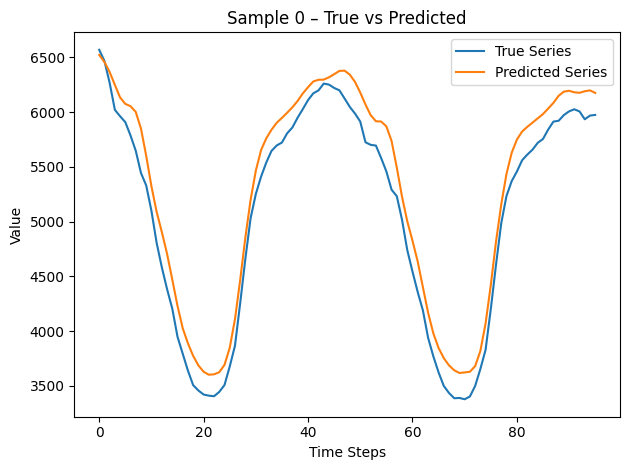

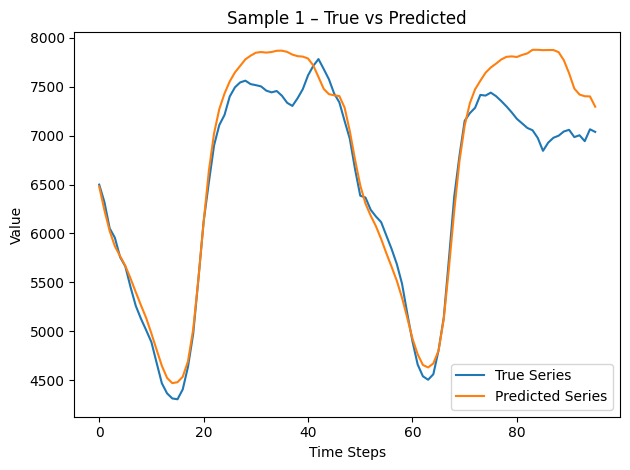

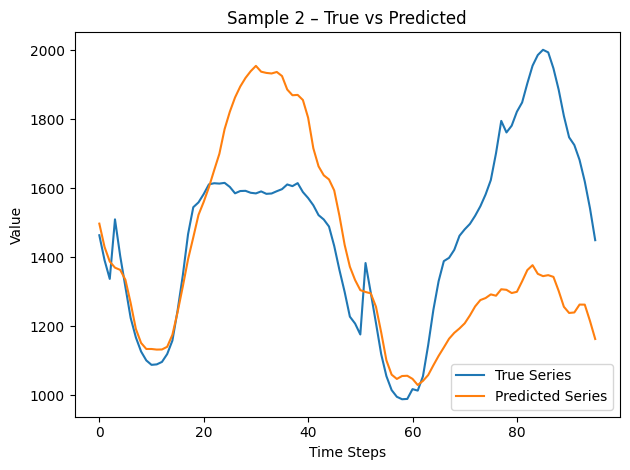

In [78]:
def rmse_np(y_true: np.ndarray, y_pred: np.ndarray, axis=None) -> np.ndarray:
    """
    Compute RMSE along the specified axis.

    Args:
      y_true, y_pred: arrays of same shape.
      axis: axis or tuple of axes over which to compute MSE before sqrt.

    Returns:
      RMSE (scalar if axis=None, else array of reduced shape).
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=axis))

rmse_val = rmse_np(y_truth, orig_preds)
# Compute RMSE
print(f"Overall RMSE: {rmse_val:.4f}")

# Time-series comparison for first 3 samples
for i in range(min(3, len(orig_preds))):
    plt.figure()
    plt.plot(y_truth[i].flatten(), label="True Series")
    plt.plot(orig_preds[i].flatten(), label="Predicted Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title(f"Sample {i} – True vs Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
# Save only the learned parameters
torch.save(model.state_dict(), "./model_weights.pt")

## Preface: HNSW Concepts

HNSW (Hierarchical Navigable Small World) builds a multi-layer proximity graph over your vectors to enable very fast approximate k-NN search:

- **Layer 0**  
  - The **densest** level, containing **all** vectors.  
  - Inserts compute exact distances within a local neighborhood (using a beam of size `ef_construction`) and link each new vector to its top-M neighbors here.

- **Layers 1…L**  
  - Each higher layer is a progressively **sparser** “shortcut” graph.  
  - Upon insertion, a vector is assigned a random max level `l_max` and placed on layers 0 through `l_max`.  
  - On these layers, each node keeps up to **M** bi-directional links chosen by a **greedy** or small-beam search during index build.

### Search procedure (“fuzzy funnel”)

1. **Entry at top layer**  
   - Begin at a single entry node in the highest non-empty layer.

2. **Greedy descent (beam = 1) on layers L → 1**  
   - At each layer, examine up to **M** neighbors of your current node.  
   - **Move** to the single neighbor that is strictly closer to your query (hill-climbing).  
   - When no neighbor is closer, **“drop”** down to that same node’s copy on the next lower layer.

3. **Beam search (beam = ef) on layer 0**  
   - Once at layer 0, switch to a **best-first** search:  
     - Maintain a **min-heap** of up to `ef` candidate nodes (the “light beams”).  
     - Maintain a **max-heap** of your top-k results, evicting the worst when a better neighbor is found.  
   - Larger `ef` ⇒ more thorough exploration (higher recall) but slower queries.

### Key trade-offs

- **M (max links per node)**  
  - ↑ M → better connectivity & recall  
  - ↓ M → lower memory & faster build

- **ef_construction (build-time beam)**  
  - ↑ ef_construction → higher-quality links & recall  
  - ↓ ef_construction → faster indexing

- **ef (query-time beam)**  
  - ↑ ef → more accurate search, slower queries  
  - ↓ ef → faster queries, lower recall

---

### Maze analogy

- On **upper, sparse layers**, you hold a single narrow beam (beam=1) and greedily follow the brightest corridor to funnel you toward the right region. If your current corrider is already brightest continue down.  
- On the **dense ground floor** (layer 0), you shine **multiple beams** (beam=ef) in parallel, exploring the top ef corridors at once but only keeping the k best endpoints. 

This two-stage “zoom in, then beam” yields HNSW’s hallmark speed-vs-accuracy balance.  


## 1. Embed & Index Training Data

In [23]:
# 3) Load the state dict
state_dict = torch.load(
    "./model_weights.pt",
    map_location=device
)
model.load_state_dict(state_dict)
embedder = model.model.encoder.embedder

/var/folders/mc/zjvn922n3wjgsmfd_5__n97w0000gn/T/ipykernel_79473/1897148769.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [25]:
import hnswlib
from torch import nn

# 1) Define the unfolding operation once, using the same patch/stride config
#    This will slide a window of size (patch_length × 1) across the time dimension.
unfold = nn.Unfold(
    kernel_size=(cfg.patch_length, 1),
    stride=(cfg.stride, 1),
)

In [42]:
from transformers.models.patchtst.modeling_patchtst import PatchTSTPatchify

# 1) Initialize once with your config
patchify = PatchTSTPatchify(cfg).to(device)

def get_embedding(x: torch.Tensor) -> np.ndarray:
    """
    Compute a fixed-size embedding for a batch of time-series inputs
    using PatchTSTPatchify under the hood.
    
    Args:
      x: Tensor of shape (B, CTX_LEN, C)
         B = batch size,
         CTX_LEN = number of time steps,
         C = number of input channels.
    
    Returns:
      A NumPy array of shape (B, d_model).
    """
    model.eval()
    
    # Step 1: move to device
    B, T, C = x.shape
    x = x.to(device)  # (B, CTX_LEN, C)
    
    # Step 2: patchify → (B, C, num_patches, patch_length)
    patches = patchify(x)
    assert patches.ndim == 4, f"patchify output dims {patches.shape}"
    _, Cp, P, L = patches.shape
    assert Cp == C, f"channels mismatch: got {Cp}, expected {C}"
    
    # Step 3: embed each patch → (B, C, P, d_model)
    with torch.no_grad():
        emb = embedder(patches)
    assert emb.ndim == 4, f"embedder output dims {emb.shape}"
    _, Cp2, P2, d_model = emb.shape
    assert Cp2 == C and P2 == P, f"embed mismatch: {emb.shape}"
    
    # Step 4: pool → (B, d_model)
    rep = emb.mean(dim=2).mean(dim=1)  
    assert rep.ndim == 2 and rep.shape[0] == B and rep.shape[1] == d_model
    
    # Step 5: to numpy
    out = rep.cpu().numpy()
    return out

In [45]:
# -------------------------------
# 2) Gather embeddings & targets
# -------------------------------

all_train_embs, all_train_targets = [], []
for batch in train_loader:
    x_batch = batch["past"]    # (B, CTX_LEN, C)
    y_batch = batch["future"]  # (B, PRED_LEN, C)

    all_train_embs.append(get_embedding(x_batch))
    all_train_targets.append(y_batch.numpy())

all_train_embs   = np.vstack(all_train_embs)   # (N_train, d_model)
all_train_targets = np.vstack(all_train_targets)

all_test_embs, all_test_targets = [], []
for batch in test_loader:
    x_batch = batch["past"]
    y_batch = batch["future"]

    all_test_embs.append(get_embedding(x_batch))
    all_test_targets.append(y_batch.numpy())

all_test_embs   = np.vstack(all_test_embs)    # (N_test, d_model)
all_test_targets = np.vstack(all_test_targets)



[DEBUG] patches shape: torch.Size([128, 1, 369, 16])  # (B,C,num_patches,patch_length)
[DEBUG] emb shape:     torch.Size([128, 1, 369, 128])  # (B,C,num_patches,d_model)
[DEBUG] rep shape:     torch.Size([128, 128])  # (B,d_model)
[DEBUG] numpy shape:   (128, 128)
[DEBUG] patches shape: torch.Size([128, 1, 369, 16])  # (B,C,num_patches,patch_length)
[DEBUG] emb shape:     torch.Size([128, 1, 369, 128])  # (B,C,num_patches,d_model)
[DEBUG] rep shape:     torch.Size([128, 128])  # (B,d_model)
[DEBUG] numpy shape:   (128, 128)
[DEBUG] patches shape: torch.Size([128, 1, 369, 16])  # (B,C,num_patches,patch_length)
[DEBUG] emb shape:     torch.Size([128, 1, 369, 128])  # (B,C,num_patches,d_model)
[DEBUG] rep shape:     torch.Size([128, 128])  # (B,d_model)
[DEBUG] numpy shape:   (128, 128)
[DEBUG] patches shape: torch.Size([128, 1, 369, 16])  # (B,C,num_patches,patch_length)
[DEBUG] emb shape:     torch.Size([128, 1, 369, 128])  # (B,C,num_patches,d_model)
[DEBUG] rep shape:     torch.Size([

In [46]:
# ---------------------------------
# 3) Build the HNSW index with hnswlib
# ---------------------------------
# Note: Building index on train embeddings. We'll use this index to recall test set embeddings.
D, N = all_train_embs.shape[1], all_train_embs.shape[0]
index = hnswlib.Index(space='l2', dim=D)

# Initialize index:
#  - max_elements: number of vectors we will store
#  - ef_construction: controls graph connectivity during build
#  - M: max connections per element (controls memory & recall)
index.init_index(
    max_elements=N,
    ef_construction=200,  # larger → slower build, higher quality
    M=16                  # larger → more memory, higher recall
)

# Add all embeddings to the index, with labels 0…N-1
index.add_items(all_train_embs, np.arange(N))

# Set ef (query-time beam width):
#  - trade-off between speed and recall
index.set_ef(50)  # larger → more accurate, slower queries

print(f"Indexed {N} embeddings of dimension {D}")

Indexed 920948 embeddings of dimension 128


## 2. HNSW vs Brute Force

In [48]:
import time
import numpy as np
from sklearn.neighbors import NearestNeighbors

# PARAMETERS
k = 5                  # number of neighbors
num_queries = 100      # how many queries to test

# Use test embeddings for queries
all_embeddings = all_train_embs  # (N, D) array from your HNSW setup
queries = all_test_embs[:num_queries]

# SAMPLE QUERIES
# true_targets for test set if needed
true_test_targets = all_test_targets[:num_queries]

# 1) Brute-force kNN
brute_nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
brute_nn.fit(all_embeddings)
start = time.time()
dist_brute, ind_brute = brute_nn.kneighbors(queries)
brute_time = time.time() - start

# 2) HNSW kNN
start = time.time()
ind_hnsw, dist_hnsw = index.knn_query(queries, k=k)
hnsw_time = time.time() - start

# 3) Compute recall@k
recall_scores = [
    len(set(ind_brute[i]).intersection(set(ind_hnsw[i]))) / k
    for i in range(num_queries)
]
mean_recall = np.mean(recall_scores)

# 5) Distance error metric
mean_dist_error = np.mean(np.abs(dist_brute - dist_hnsw))
print(f"Mean |d_brute - d_hnsw| over all top-{k}: {mean_dist_error:.4f}")

# 6) Speedup multiplier
speedup = brute_time / hnsw_time
print(f"Brute-force total time: {brute_time:.4f}s "
      f"({brute_time/num_queries:.6f}s/query)")
print(f"HNSW     total time: {hnsw_time:.4f}s "
      f"({hnsw_time/num_queries:.6f}s/query)")
print(f"mean recall@{k}: {mean_recall*100:.2f}%")

Mean |d_brute - d_hnsw| over all top-5: 16.1260
Brute-force total time: 0.3219s (0.003219s/query)
HNSW     total time: 0.0435s (0.000435s/query)
mean recall@5: 100.00%
